In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard

In [ ]:
import tensorflow_hub as hub

In [ ]:
import tensorflow as tf

In [ ]:
classfier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224,224,3)

In [ ]:
classfier= tf.keras.Sequential([hub.KerasLayer(classfier_url, input_shape=IMAGE_SHAPE)])

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
army_person = tf.keras.utils.get_file("image3.jpg","https://m.economictimes.com/thumb/msid-53517853,width-1200,height-900,resizemode-4,imgsize-310171/tech/ites/you-dont-need-internet-to-book-a-cab-anymore.jpg")

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

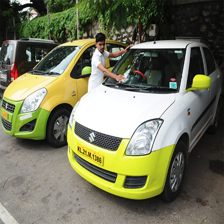

In [ ]:
army_person = Image.open(army_person).resize((224,224))
army_person

In [ ]:
army_person = np.array(army_person)/255.0
army_person.shape

(224, 224, 3)

In [ ]:
result = classfier.predict(army_person[np.newaxis])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0])

In [ ]:
imagenet_labels[predicted_class]

'cab'

# transfer learning

In [ ]:
flower_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_root = tf.keras.utils.get_file("flower_photos",flower_dataset_url,untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(dataset_root,target_size=(224,224))

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

In [ ]:
result_batch = classfier.predict(image_batch)
result_batch.shape

(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['cardoon', 'cardoon', 'bee', 'daisy', 'picket fence', 'goldfish',
       'pot', 'bee', 'bee', 'daisy', 'balloon', 'bee', 'daisy', 'bee',
       'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'spider web',
       'window screen', 'sulphur butterfly', 'Bedlington terrier',
       'velvet', 'sea urchin', 'patio', 'rapeseed', 'mushroom', 'ladybug',
       'daisy', 'daisy', 'ice cream'], dtype='<U30')

In [ ]:
import matplotlib.pyplot as plt

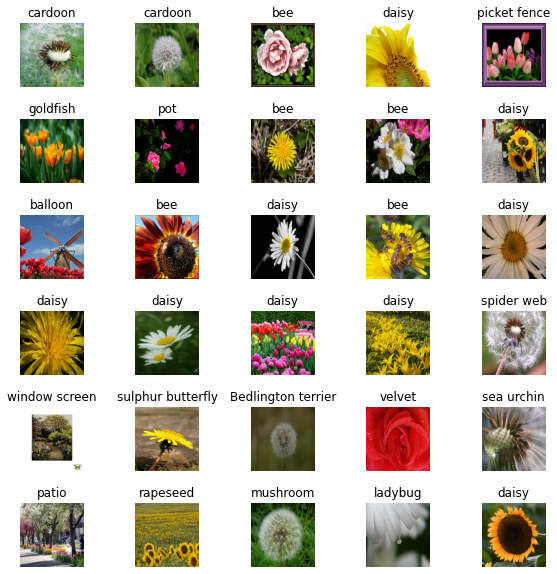

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.5)
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i])
    plt.title(predicted_class_names[i])
    plt.axis('off')
plt.show()

training the model to really understand the new dataset

In [ ]:
feature_extractor_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=IMAGE_SHAPE)

In [ ]:
feature_batch =feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
# new model wrapper
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
prediction = model(image_batch)
prediction.shape

TensorShape([32, 5])

In [ ]:
# compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
steps = np.floor(image_data.samples/image_data.batch_size)

In [ ]:
history = model.fit_generator(image_data, epochs=3, steps_per_epoch= steps)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/3
114/114 [==============================] - 125s 1s/step - loss: 0.6594 - accuracy: 0.7721
Epoch 2/3
114/114 [==============================] - 130s 1s/step - loss: 0.3450 - accuracy: 0.8829
Epoch 3/3
114/114 [==============================] - 126s 1s/step - loss: 0.2716 - accuracy: 0.9109


# prediction

In [ ]:
class_names = np.array(list(image_data.class_indices.keys()))

In [ ]:
predicted_batch = model.predict(image_batch)
pred_id = np.argmax(predicted_batch,axis = -1)
predicted_label_batch = class_names[pred_id]
actual_id = np.argmax(label_batch, axis=-1)

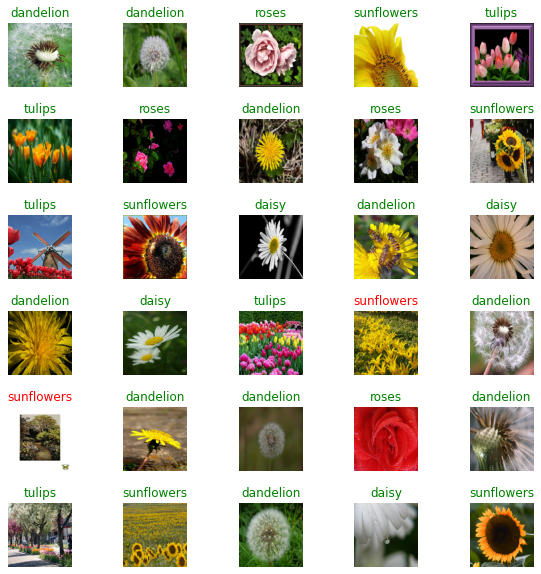

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.5)
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i])
    color ="green" if pred_id[i] == actual_id[i] else "red" 
    plt.title(predicted_label_batch[i],color=color)
    plt.axis('off')
plt.show()

In [ ]:
model.save('flower_classifier',save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: flower_classifier/assets


INFO:tensorflow:Assets written to: flower_classifier/assets
